In [53]:
#Importinng necessary libraries

import pandas as pd
import numpy as np
import zipfile
import requests
import io
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from collections import defaultdict

In [54]:
# Data Loading

print("Downloading Data...")
url = 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'

print("Getting request...")
r = requests.get(url)
print("Request received.")
print("Extracting zip file...")
z = zipfile.ZipFile(io.BytesIO(r.content))
print("Done!")


Getting request...
Request received.
Extracting zip file...
Done!


In [55]:
#Loaading the MovieLens user ratings and movie metadata into seperate dataframes

rating_columns = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv(z.open('ml-100k/u.data'),
                      sep='\t',
                      names=rating_columns)

movie_columns = ['movie_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL']

genre_columns = ['unknown', 'Action', 'Adventure', 'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary',
                 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

movie_columns.extend(genre_columns)
movies = pd.read_csv(z.open('ml-100k/u.item'),
                     sep='|',
                     names=movie_columns,
                     encoding='latin-1')

In [56]:
#merging the user ratings and movie metadata into one single dataframe for easier access

movie_ratings = pd.merge(movies, ratings)
print("Data loaded successfully.\n")

Data loaded successfully.



In [57]:
print("CONTENT-BASED FILTERING MODEL (CB)")
movie_genres = movies.copy()

CONTENT-BASED FILTERING MODEL (CB)


In [58]:
#Function to get specific genre of the movie

def get_genre_string(row):
    active_genres = [genre for genre, is_active in zip(genre_columns, row[genre_columns]) if is_active]
    return ' '.join(active_genres)

In [59]:
# Creating a movie similarity matrix by converting genre text into TF-IDF vectors and calculating cosine similarity

movie_genres['genres'] = movie_genres.apply(get_genre_string, axis=1)
content_df = movie_genres[['movie_id', 'title', 'genres']]
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(content_df['genres'])
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
indices = pd.Series(content_df.index, index=content_df['title']).drop_duplicates()

In [60]:
# Creating the Content Based Recommendation logic

def content_based_recommendations(title, similarity_matrix=cosine_sim):

    if title not in indices:
        return f"Movie '{title}' not found in the dataset."

    idx = indices[title]

    sim_scores = list(enumerate(similarity_matrix[idx]))

    sim_scores = sorted(sim_scores,
                        key=lambda x: x[1],
                        reverse=True)

    sim_scores = sim_scores[1:11]

    movie_indices = [i[0] for i in sim_scores]

    return content_df['title'].iloc[movie_indices]


print("Content-Based (CB) model built successfully.\n")

Content-Based (CB) model built successfully.



In [61]:
print("COLLABORATIVE FILTERING MODEL (CF)")

COLLABORATIVE FILTERING MODEL (CF)


Checking for the best n_component value such that it reaches the best precision without overfitting and is not too generalized to avoid underfitting
Preparing test data for evaluation.
Preparation complete.

HYPERPARAMETER TUNING
Analyzing the impact of n_components...
  n_components = 5, Precision@10 = 0.2632
  n_components = 10, Precision@10 = 0.2922
  n_components = 20, Precision@10 = 0.2883
  n_components = 30, Precision@10 = 0.2720
  n_components = 40, Precision@10 = 0.2538
  n_components = 50, Precision@10 = 0.2349
  n_components = 60, Precision@10 = 0.2198
  n_components = 70, Precision@10 = 0.2115
  n_components = 80, Precision@10 = 0.2009
  n_components = 100, Precision@10 = 0.1815
  n_components = 120, Precision@10 = 0.1605
  n_components = 150, Precision@10 = 0.1415
Optimal n_component is:  10

Analysis complete.



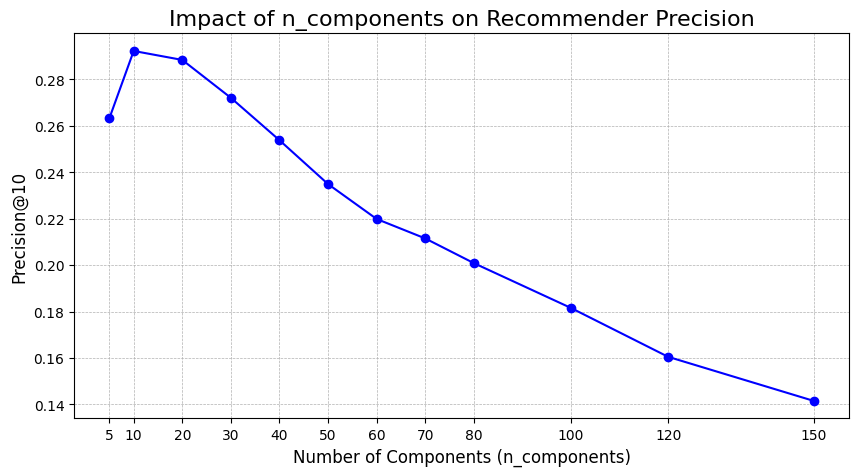

In [62]:
# Checking the best value for n_components for most optimal solution that avoids overfitting and underfitting of the model

print("Checking for the best n_component value such that it reaches the best precision without overfitting and is not too generalized to avoid underfitting")
train_ratings, test_ratings = train_test_split(ratings, test_size=0.25, random_state=42)
user_item_matrix_train = train_ratings.pivot(index='user_id',
                                             columns='movie_id',
                                             values='rating').fillna(0)

print("Preparing test data for evaluation.")
user_test_true = defaultdict(list)
for _, row in test_ratings.iterrows():
    if row['rating'] >= 4.0:
        user_test_true[row['user_id']].append(row['movie_id'])
print("Preparation complete.\n")

print("HYPERPARAMETER TUNING")
print("Analyzing the impact of n_components...")

# Define a range of n_components values to test
n_components_range = [5, 10, 20, 30, 40, 50, 60, 70, 80, 100, 120, 150]
precision_scores = []
optimal_n = 0
max_precision = 0.0
for n in n_components_range:
    # Training SVD model for each n_component value
    svd = TruncatedSVD(n_components=n, random_state=42)
    svd.fit(user_item_matrix_train)

    # Creating the predicted ratings matrix
    user_ids_train = user_item_matrix_train.index
    movie_ids_train = user_item_matrix_train.columns
    predicted_ratings = np.dot(svd.transform(user_item_matrix_train), svd.components_)
    predicted_ratings_df = pd.DataFrame(predicted_ratings,
                                        index=user_ids_train,
                                        columns=movie_ids_train)

    # Evaluating for this specific model
    precisions = dict()
    for user_id, true_items in user_test_true.items():
        if not true_items or user_id not in predicted_ratings_df.index: continue

        # Getting recommendations
        user_ratings = predicted_ratings_df.loc[user_id]
        movies_rated_in_train = user_item_matrix_train.loc[user_id]
        rated_movie_ids = movies_rated_in_train[movies_rated_in_train > 0].index
        recommendations = user_ratings.drop(rated_movie_ids, errors='ignore')
        predicted_items = recommendations.sort_values(ascending=False).head(10).index.tolist()

        # Calculating precision
        hits = len(set(predicted_items) & set(true_items))
        precisions[user_id] = hits / 10.0

    current_precision = np.mean(list(precisions.values()))
    precision_scores.append(current_precision)
    if current_precision > max_precision:
        max_precision = current_precision
        optimal_n = n
    print(f"  n_components = {n}, Precision@10 = {current_precision:.4f}")

print("Optimal n_component is: ", optimal_n)
print("\nAnalysis complete.\n")

plt.figure(figsize=(10, 5))
plt.plot(n_components_range,
         precision_scores,
         marker='o',
         linestyle='-',
         color='b')

plt.title('Impact of n_components on Recommender Precision', fontsize=16)
plt.xlabel('Number of Components (n_components)', fontsize=12)
plt.ylabel('Precision@10', fontsize=12)
plt.xticks(n_components_range)
plt.grid(True,
         which='both',
         linestyle='--',
         linewidth=0.5)
plt.show()

In [63]:
# Performing matrix factorization using SVD on the user-item matrix to predict missing ratings

user_item_matrix = ratings.pivot_table(index='user_id',
                                       columns='movie_id',
                                       values='rating')

user_item_matrix.fillna(0, inplace=True)


svd = TruncatedSVD(n_components=optimal_n, random_state=42)

svd_matrix = svd.fit_transform(user_item_matrix)

predicted_ratings = np.dot(svd_matrix, svd.components_)

predicted_ratings_df = pd.DataFrame(predicted_ratings,
                                    index=user_item_matrix.index,
                                    columns=user_item_matrix.columns)

In [64]:
# Creating the Collaborative Filtering Logic

def collaborative_filtering_recommendations(user_id):
    user_predicted_ratings = predicted_ratings_df.loc[user_id]

    movies_rated_by_user = user_item_matrix.loc[user_id]
    movies_rated_by_user = movies_rated_by_user[movies_rated_by_user > 0].index

    recommendations = user_predicted_ratings.drop(movies_rated_by_user)

    top_10_movie_ids = recommendations.sort_values(ascending=False).head(10).index

    top_10_movies = movies[movies['movie_id'].isin(top_10_movie_ids)]['title']

    return top_10_movies

In [65]:
print("Collaborative Filtering (CF) model built successfully.\n")

Collaborative Filtering (CF) model built successfully.



In [66]:
print("HYBRID RECOMMENDER MODEL")

HYBRID RECOMMENDER MODEL


In [67]:
# Creating the Hybrid-Recommender Logic

def hybrid_recommendations(user_id, movie_title):
    if user_id not in predicted_ratings_df.index:
        print(f"🎬 User ID {user_id} not found. Handling as a new user (cold start).")
        print(f"Returning content-based recommendations for the movie '{movie_title}':")
        return content_based_recommendations(movie_title)

    print(f"👤 Generating hybrid recommendations for User ID: {user_id}")
    print(f"🎥 Based on interest in: '{movie_title}'")

    cf_recs = collaborative_filtering_recommendations(user_id)
    cb_recs_series = content_based_recommendations(movie_title)

    cf_recs_list = list(cf_recs.head(7))

    if isinstance(cb_recs_series, str):
        hybrid_recs = cf_recs_list
    else:
        cb_recs_list = list(cb_recs_series.head(5))

        hybrid_recs = []
        seen_movies = set()

        for movie in cf_recs_list + cb_recs_list:
            if movie not in seen_movies:
                hybrid_recs.append(movie)
                seen_movies.add(movie)

    return hybrid_recs[:10]

In [68]:
# Finally runnning the project with test values (these can be changed to take input from user as well or input from previous watch-history as well)

if __name__ == '__main__':
    print("="*40)
    print("DEMONSTRATION")
    print("="*40)

    user_id_example = 50 # Use different user ID to get different recommendations
    movie_title_example = 'Star Wars (1977)' # Change as per requirement (Year is necessary, refer data-set for correct format)

    final_recommendations = hybrid_recommendations(user_id_example, movie_title_example)

    print("\n--- Final Hybrid Recommendations ---")
    for i, movie in enumerate(final_recommendations, 1):
        print(f"{i}. {movie}")

    print("\n" + "="*40 + "\n")

    user_id_cold_start = 9999 # Even if the user ID is same, changinf the movie title will give different recommendation, since this is a cold start problem
    movie_title_cold_start = 'Toy Story (1995)'

    final_recommendations_cold_start = hybrid_recommendations(user_id_cold_start, movie_title_cold_start)

    print("\n--- Final Cold Start Recommendations ---")
    for i, movie in enumerate(final_recommendations_cold_start, 1):
        print(f"{i}. {movie}")

DEMONSTRATION
👤 Generating hybrid recommendations for User ID: 50
🎥 Based on interest in: 'Star Wars (1977)'

--- Final Hybrid Recommendations ---
1. Twelve Monkeys (1995)
2. Welcome to the Dollhouse (1995)
3. Bound (1996)
4. Swingers (1996)
5. Jerry Maguire (1996)
6. Contact (1997)
7. Heat (1995)
8. Return of the Jedi (1983)
9. Empire Strikes Back, The (1980)
10. Starship Troopers (1997)


🎬 User ID 9999 not found. Handling as a new user (cold start).
Returning content-based recommendations for the movie 'Toy Story (1995)':

--- Final Cold Start Recommendations ---
1. Aladdin and the King of Thieves (1996)
2. Aristocats, The (1970)
3. Pinocchio (1940)
4. Sword in the Stone, The (1963)
5. Fox and the Hound, The (1981)
6. Winnie the Pooh and the Blustery Day (1968)
7. Balto (1995)
8. Oliver & Company (1988)
9. Swan Princess, The (1994)
10. Land Before Time III: The Time of the Great Giving (1995) (V)


Training set size: 75000
Test set size: 25000

Implementing and Training Models...
Models implemented successfully.

Calculating Evaluation Metrics for All Models...
Our CF Model Performance:
  Precision@10: 0.2922
  Recall@10:    0.2549

Popularity Recommender Performance:
  Precision@10: 0.1585
  Recall@10:    0.1358

Random Recommender Performance:
  Precision@10: 0.0091
  Recall@10:    0.0053



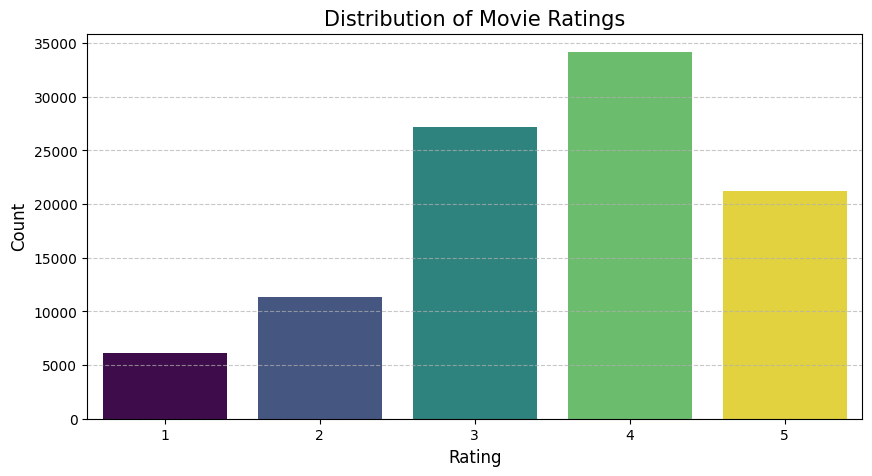

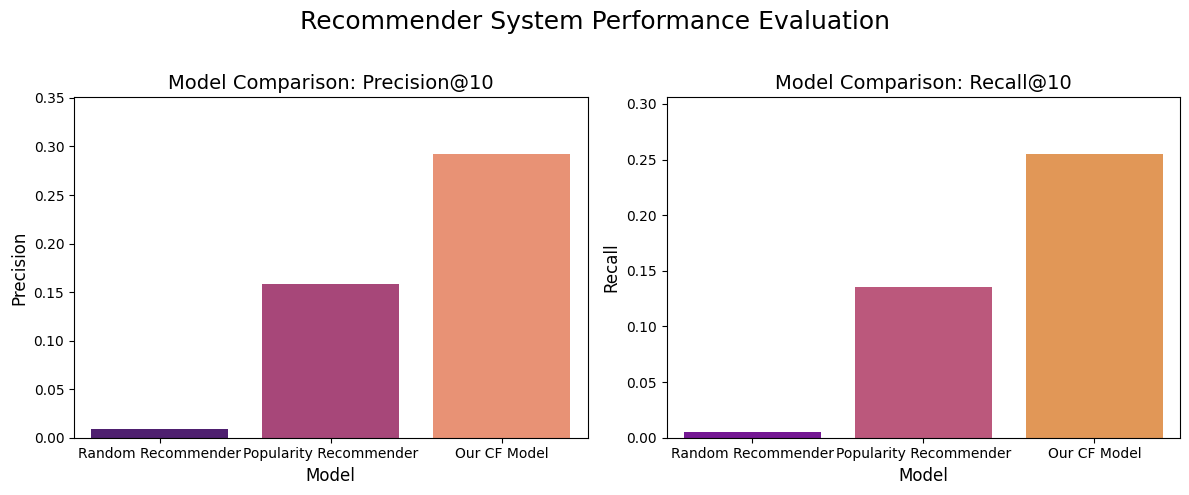

In [69]:
# Checking the evaluation metrics and Precision@10 and Recall@10 to compare current hybrid model with different models


# Training the data on test-size of 25%. This can be altered to get different results and experimented with.
train_ratings, test_ratings = train_test_split(ratings,
                                               test_size=0.25,
                                               random_state=42)
print(f"Training set size: {len(train_ratings)}")
print(f"Test set size: {len(test_ratings)}\n")

print("Implementing and Training Models...")

# --- Model 1: Collaborative Filtering (SVD) ---
user_item_matrix_train = train_ratings.pivot(index='user_id',
                                             columns='movie_id',
                                             values='rating').fillna(0)
svd = TruncatedSVD(n_components=optimal_n, random_state=42)
svd.fit(user_item_matrix_train)
user_ids_train = user_item_matrix_train.index
movie_ids_train = user_item_matrix_train.columns
predicted_ratings = np.dot(svd.transform(user_item_matrix_train), svd.components_)
predicted_ratings_df = pd.DataFrame(predicted_ratings,
                                    index=user_ids_train,
                                    columns=movie_ids_train)

# Logic to get the Collaborative-Filtering Recommendations
def get_cf_recommendations(user_id, n=10):
    if user_id not in predicted_ratings_df.index: return []
    user_ratings = predicted_ratings_df.loc[user_id]
    movies_rated_in_train = user_item_matrix_train.loc[user_id]
    rated_movie_ids = movies_rated_in_train[movies_rated_in_train > 0].index
    recommendations = user_ratings.drop(rated_movie_ids, errors='ignore')
    top_n_movie_ids = recommendations.sort_values(ascending=False).head(n).index
    return list(top_n_movie_ids)

# --- Model 2: Popularity Recommender ---
movie_popularity = train_ratings.groupby('movie_id').size().sort_values(ascending=False)
popular_movies = movie_popularity.index.tolist()

# Logic to get the Popularity Recommendation (Recommends the movies with the highest rating)
def get_popularity_recommendations(user_id, n=10):
    movies_rated_in_train = user_item_matrix_train.loc[user_id]
    rated_movie_ids = movies_rated_in_train[movies_rated_in_train > 0].index
    unseen_popular_movies = [movie for movie in popular_movies if movie not in rated_movie_ids]
    return unseen_popular_movies[:n]

# --- Model 3: Random Recommender ---
all_movie_ids = train_ratings['movie_id'].unique()

# Logic to get the Random Recommendation (Recommends randomly any movie out of the given data-set)
def get_random_recommendations(user_id, n=10):
    movies_rated_in_train = user_item_matrix_train.loc[user_id]
    rated_movie_ids = movies_rated_in_train[movies_rated_in_train > 0].index
    unseen_movies = np.setdiff1d(all_movie_ids, rated_movie_ids)
    return np.random.choice(unseen_movies, size=n, replace=False).tolist()

print("Models implemented successfully.\n")

print("Calculating Evaluation Metrics for All Models...")

# Logic to calculate the Precision@k and Recall@k (K can be changed based on the requirement)
def calculate_precision_recall_at_k(model_func, k=10):
    user_test_true = defaultdict(list)
    for _, row in test_ratings.iterrows():
        if row['rating'] >= 4.0:
            user_test_true[row['user_id']].append(row['movie_id'])

    precisions = dict()
    recalls = dict()

    for user_id, true_items in user_test_true.items():
        if not true_items or user_id not in user_item_matrix_train.index: continue

        predicted_items = model_func(user_id, n=k)
        if not predicted_items:
            precisions[user_id], recalls[user_id] = 0.0, 0.0
            continue

        hits = len(set(predicted_items) & set(true_items))
        precisions[user_id] = hits / k
        recalls[user_id] = hits / len(true_items)

    mean_precision = np.mean(list(precisions.values()))
    mean_recall = np.mean(list(recalls.values()))
    return mean_precision, mean_recall

# Populating the models in dictionary format to store the output
models = {
    "Our CF Model": get_cf_recommendations,
    "Popularity Recommender": get_popularity_recommendations,
    "Random Recommender": get_random_recommendations
}

model_performance = {'Precision@10': {}, 'Recall@10': {}}

for model_name, model_func in models.items():
    precision, recall = calculate_precision_recall_at_k(model_func)
    model_performance['Precision@10'][model_name] = precision
    model_performance['Recall@10'][model_name] = recall
    print(f"{model_name} Performance:")
    print(f"  Precision@10: {precision:.4f}")
    print(f"  Recall@10:    {recall:.4f}\n")

# --- Graph 1: Distribution of Movie Ratings ---
plt.figure(figsize=(10, 5))
sns.countplot(x='rating',
              data=ratings,
              palette='viridis',
              hue='rating',
              legend=False)

plt.title('Distribution of Movie Ratings', fontsize=15)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# --- Graph 2: Model Performance Comparison ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_order = ["Random Recommender", "Popularity Recommender", "Our CF Model"]

# Plotting Precision
precision_df = pd.DataFrame.from_dict(model_performance['Precision@10'],
                                      orient='index',
                                      columns=['score']).loc[plot_order]

sns.barplot(x=precision_df.index,
            y=precision_df.score,
            ax=axes[0],
            palette='magma',
            hue=precision_df.index,
            legend=False)

axes[0].set_title('Model Comparison: Precision@10', fontsize=14)
axes[0].set_ylabel('Precision', fontsize=12)
axes[0].set_xlabel('Model', fontsize=12)
axes[0].set_ylim(0, max(model_performance['Precision@10'].values()) * 1.2)

# Plotting Recall
recall_df = pd.DataFrame.from_dict(model_performance['Recall@10'],
                                   orient='index',
                                   columns=['score']).loc[plot_order]

sns.barplot(x=recall_df.index,
            y=recall_df.score,
            ax=axes[1],
            palette='plasma',
            hue=recall_df.index,
            legend=False)

axes[1].set_title('Model Comparison: Recall@10', fontsize=14)
axes[1].set_ylabel('Recall', fontsize=12)
axes[1].set_xlabel('Model', fontsize=12)
axes[1].set_ylim(0, max(model_performance['Recall@10'].values()) * 1.2)

plt.suptitle('Recommender System Performance Evaluation', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()